### Get Grid from picture

Current state of project
- adjust perspective_transform that if image is slightly turned, it doesnt crash
- find corner robust
- crop images in right order for other pics!!


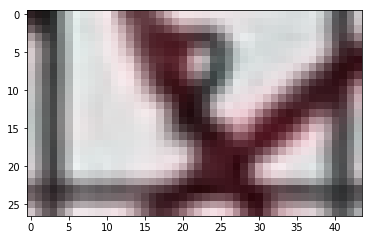

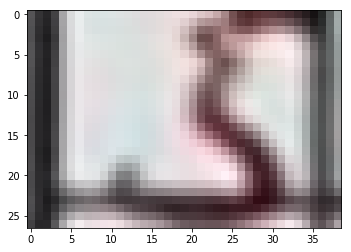

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

def processing(img, skip_dilate=False):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    process = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    process = cv2.adaptiveThreshold(process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    process = cv2.bitwise_not(process, process)
    return process

def _resize(img, target_img_height):
    raw_h, raw_w = img.shape[:2]
    target_w = (raw_w * target_img_height) / raw_h
    img = cv2.resize(img, (int(target_w), int(target_img_height)))
    return img

def find_corners(img):
    ext_contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ext_contours = ext_contours[0] if len(ext_contours) == 2 else ext_contours[1]
    ext_contours = sorted(ext_contours, key=cv2.contourArea, reverse=True)
    for c in ext_contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        if len(approx) == 4:
            return approx

def order_corner_points(corners):
    corners = [(corner[0][0], corner[0][1]) for corner in corners]
    top_r, top_l, bottom_l, bottom_r = corners[0], corners[1], corners[2], corners[3]
    return top_l, top_r, bottom_r, bottom_l


# Crop the image
def perspective_transform(image, corners):
    ordered_corners = order_corner_points(corners)
    top_l, top_r, bottom_r, bottom_l = ordered_corners
    width_A = np.sqrt(((bottom_r[0] - bottom_l[0]) ** 2) + ((bottom_r[1] - bottom_l[1]) ** 2))
    width_B = np.sqrt(((top_r[0] - top_l[0]) ** 2) + ((top_r[1] - top_l[1]) ** 2))
    width = max(int(width_A), int(width_B))

    height_A = np.sqrt(((top_r[0] - bottom_r[0]) ** 2) + ((top_r[1] - bottom_r[1]) ** 2))
    height_B = np.sqrt(((top_l[0] - bottom_l[0]) ** 2) + ((top_l[1] - bottom_l[1]) ** 2))
    height = max(int(height_A), int(height_B))

    dimensions = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1],
                           [0, height - 1]], dtype="float32")

    ordered_corners = np.array(ordered_corners, dtype="float32")
    grid = cv2.getPerspectiveTransform(ordered_corners, dimensions)
    # Return the transformed image
    return cv2.warpPerspective(image, grid, (width, height))

def morph_transform(image): 
    gray_scale=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    th1,img_bin = cv2.threshold(gray_scale,150,225,cv2.THRESH_BINARY)
    lineWidth = 1
    lineMinWidth = 35
    kernal1 = np.ones((lineWidth,lineWidth), np.uint8)
    kernal1h = np.ones((1,lineWidth), np.uint8)
    kernal1v = np.ones((lineWidth,1), np.uint8)

    kernal6 = np.ones((lineMinWidth,lineMinWidth), np.uint8)
    kernal6h = np.ones((1,lineMinWidth), np.uint8)
    kernal6v = np.ones((lineMinWidth,1), np.uint8)
    img_bin_h = cv2.morphologyEx(~img_bin, cv2.MORPH_CLOSE, kernal1h) # bridge small gap in horizonntal lines
    img_bin_h = cv2.morphologyEx(img_bin_h, cv2.MORPH_OPEN, kernal6h) # kep ony horiz lines by eroding everything else in hor direction
    img_bin_v = cv2.morphologyEx(~img_bin, cv2.MORPH_CLOSE, kernal1v)  # bridge small gap in vert lines
    img_bin_v = cv2.morphologyEx(img_bin_v, cv2.MORPH_OPEN, kernal6v)# kep ony vert lines by eroding everything else in vert direction
    def fix(img):
        img[img>127]=255
        img[img<127]=0
        return img

    img_bin_final = fix(fix(img_bin_h)|fix(img_bin_v))
    finalKernel = np.ones((5,5), np.uint8)
    img_bin_final=cv2.dilate(img_bin_final,finalKernel,iterations=1)
    return img_bin_final

def split_image_in_two_parts(image):
    img_bin_final =  morph_transform(image)
    ret, labels, stats,centroids = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
    for x,y,w,h,area in stats[2:]:
        if(h > 0.6*image.shape[0]):
            scoreGrid_Extract =image[y:y+h, x+w:image.shape[1]]
            player_Name_Grid = image[y:y+h, 0:x]  
    return scoreGrid_Extract,player_Name_Grid

def crop_scores_from_grid(image):
    img_bin_final =  morph_transform(image)
    ret, labels, stats,centroids = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
    idx = 1
    id_img = 1
    my_dict = {}
    for x,y,w,h,area in stats[2:]:
        if(w > 0.01*image.shape[1]  and idx > 8):
            scoreGrid_Extract =image[y:y+h+5, x-5:x+w+5]
            scoreGrid_Extract = _resize(scoreGrid_Extract,27)
            cv2.imwrite("Test"+str(id_img)+"Pic.png",scoreGrid_Extract )
            my_dict[id_img] = scoreGrid_Extract
            id_img +=1
        idx += 1
    plt.imshow(my_dict[18])
    plt.show()
    plt.imshow(my_dict[17])
    plt.show()
    return my_dict

def crop_names_from_grid(image):
    img_bin_final =  morph_transform(image)
    ret, labels, stats,centroids = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
    idx = 1
    id_img = 1
    my_dict = {}
    for x,y,w,h,area in stats[2:]:
        if(idx > 8):
            scoreGrid_Extract =image[y:y+h+5, x-5:x+w+5]
            my_dict[id_img] = scoreGrid_Extract
            id_img +=1
        idx += 1
    return my_dict

def extract():
    img = cv2.imread('Basketball_Score_Pic.jpg')
    processed_grid = processing(img)
    grid = find_corners(processed_grid)
    transformed = perspective_transform(img, grid)
    cropped_score_grid , cropped_player_name_grid = split_image_in_two_parts(transformed)
    dic_images = crop_scores_from_grid(cropped_score_grid)
    #dic_names = crop_names_from_grid(cropped_player_name_grid)
extract()